In [625]:
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import cv2
from os import listdir

set1_dir = "../images/set1/"
set2_dir = "../images/set2/"
set3_dir = "../images/set3/"

set1_images = [np.array(cv2.imread(set1_dir + f, cv2.IMREAD_GRAYSCALE)) for f in sorted(listdir(set1_dir))]
set2_images = [np.array(img.imread(set2_dir + f, cv2.IMREAD_GRAYSCALE)) for f in sorted(listdir(set2_dir))]
set3_images = [np.array(img.imread(set3_dir + f, cv2.IMREAD_GRAYSCALE)) for f in sorted(listdir(set3_dir))]

In [626]:
def imregionalmax(image, kernel=None):
    """Find the regional max of the image. An approximation of MATLAB's
    imregionalmax function. Result only differs when surrounding pixels
    have the same value as the center.

    Parameters:
    - image: the input image
    - kernel: the size of the neiborhood region, default is 3x3, i.e.
              neighboring 8 pixels.
    Returns:
    - a bitmask image, where '1' indicates local maxima.
    Author:
    - Yu Fang
    References:
    - https://github.com/bhardwajvijay/Utils/blob/master/utils.cpp
    - https://stackoverflow.com/questions/5550290/find-local-maxima-in-grayscale-image-using-opencv
    """
    # dialate the image so that small values are replaced by local max
    local_max = cv2.dilate(image, kernel)
    # non-local max pixels (excluding pixel w/ constant 3x3 neighborhood)
    # will be replaced by local max, so the values will increase. remove them.
    # so the result is either local max or constant neighborhood.
    max_mask = image >= local_max
    # erode the image so that high values are replaced by local min
    local_min = cv2.erode(image, kernel)
    # only local min pixels and pixels w/ constant 3x3 neighborhood
    # will stay the same, otherwise pixels will be replaced by the local
    # min and become smaller. We only take non-local min, non-constant values.
    min_mask = image > local_min
    # boolean logic hack
    #   (local max || constant) && (!local min && !constant)
    # = local max && !local min && !constant
    # = local max && !constant
    return (max_mask & min_mask).astype(np.uint8)

In [627]:
def est_homography(src, dest):
    """ Compute the homography matrix from (x_src, y_src) to (x_dest, y_dest).
    Parameters:
    - src: (x,y) coordinates of N source pixels, where coordinates are row vectors,
           so the matrix has dimension Nx2 (N>=4).
    - dest: (x,y) coordinates of N destination pixels, where coordinates are row vectors,
            so the matrix has dimension Nx2 (N>=4).
    Returns:
    - the homography matrix such that H @ [x_src, y_src, 1].T = [x_dest, y_dest, 1].T
    Author:
    - Yu Fang
    """
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)
    # take the right singular vector x corresponding to the least singular value
    # s.t. ||Ax - 0||^2 is minimized
    return V.T[:, 8].reshape(3, 3)

In [628]:
def apply_homography(H, src):
    """ Apply the homography H to src
    Parameters:
    - H: the 3x3 homography matrix
    - src: (x,y) coordinates of N source pixels, where coordinates are row vectors,
           so the matrix has dimension Nx2 (N>=4).
    Returns:
    - src: (x,y) coordinates of N destination pixels, where coordinates are row vectors,
           so the matrix has dimension Nx2 (N>=4).
    Author:
    - Yu Fang
    """
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
    return (dest / dest[:,[2]])[:,0:2]

In [629]:
def drawMatches(image1, kp1, image2, kp2, idx_pairs):
    """A wrapper around OpenCV's drawMatches.
    
    Parameters:
    - image1: the first image
    - kp1: *matrix indices* of the keypoints from image 1
           (Nx2 numpy array, where N is the number of keypoints)
    - image2: the second image
    - kp2: *matrix indices* of the keypoints from image 2 
           (Nx2 numpy array, where N is the number of keypoints)
    - idx_pairs: pairs of matching indices, e.g. if kp1[3] 
                 matches kp2[5], then idx_pairs=[[3,5],...]
                 (Kx2 numpy array, where K is the number of matches)
    Returns:
    - an image showing matching points
    Author:
    - Yu Fang
    """
    # note that the coordinates are reversed because the difference
    # between matrix indexing & coordinates.
    keypt1 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp1.tolist()]
    keypt2 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp2.tolist()]
    matches = [cv2.DMatch(pair[0], pair[1], 0) for pair in idx_pairs.tolist()]
    return cv2.drawMatches(image1, keypt1, image2, keypt2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

In [630]:
def amns(C, n_best):
    '''
    Adaptive Non-Maximal Suppression
    '''
    # Obtain local maxima of C
    local_maxima = imregionalmax(C)
    # Find the (x,y) coordinates for the local maxima
    coords = np.array([[row, col] for row in range(0, local_maxima.shape[0]) for col in range(0, local_maxima.shape[1]) if local_maxima[row, col] == 1])
    r = {}
    for c in coords:
        r[tuple(c)] = np.inf
    # For each local maxima, check the corner response relative to every other corner 
    c_robust = 0.9
    C_scaled = c_robust * C
    for c in coords:
        # Obtain the list of suppressing points
        suppressing_points = np.array(np.where(C[c[0], c[1]] < C_scaled)).T
        
        # Calculate distances from current points to supressing points
        distances = np.sum(np.abs(suppressing_points - np.array([c[0], c[1]])), axis=1)

        # Update the minimum distance for the current point
        r[tuple(c)] = np.sort(distances)[0] if len(distances) > 0 else r[tuple(c)]

    return np.array([c[0] for c in sorted(r.items(), key=lambda t: t[1], reverse=True)][:n_best])

In [631]:
# Obtain feature points for set1 images
set1_feature_points = []
strongest_corners = 500
block_size = 4
k_size = 3
k = 0.04
for im in set1_images:
    set1_feature_points.append(amns(cv2.cornerHarris(im, block_size, k_size, k), strongest_corners))


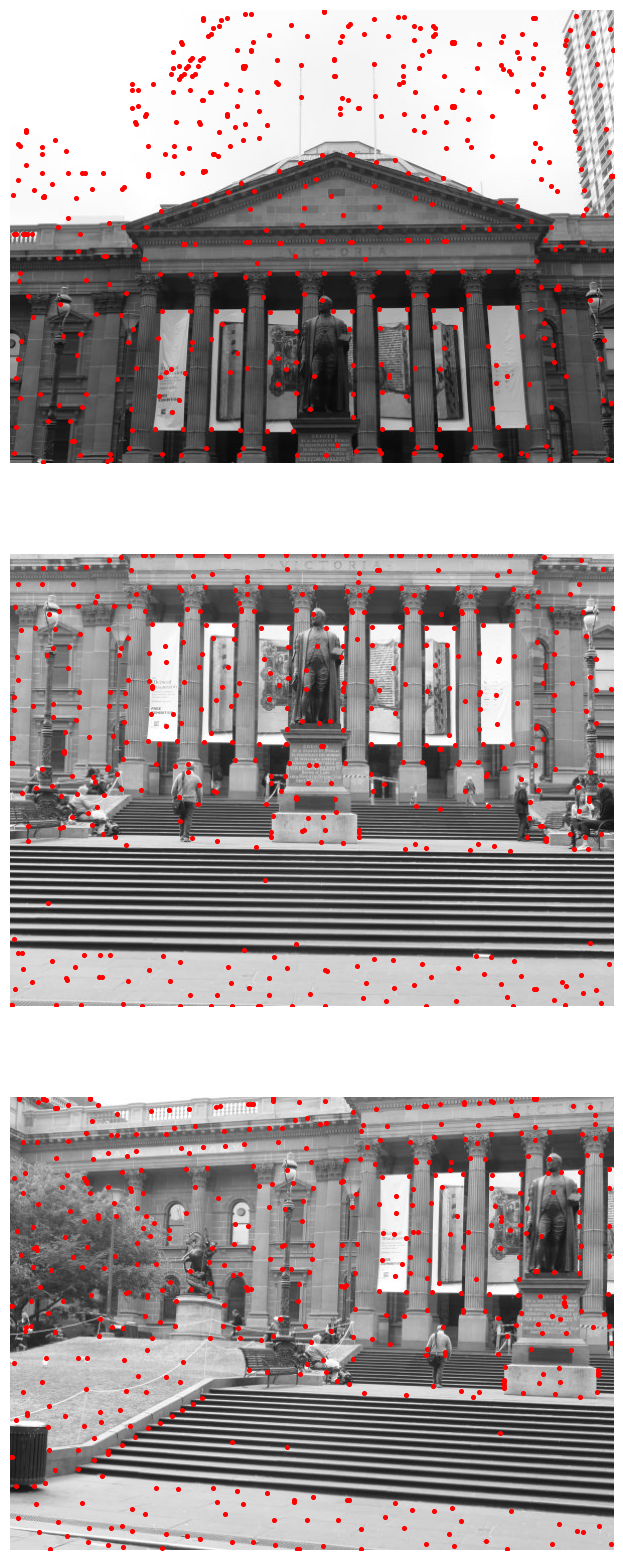

In [632]:
fig = plt.figure(figsize=(50,20))
for i in range(len(set1_images)):
    fig.add_subplot(3,1,i + 1)
    plt.imshow(cv2.cvtColor(set1_images[i], cv2.COLOR_BGR2RGB))
    plt.scatter(set1_feature_points[i][:, 1], set1_feature_points[i][:, 0], c='r', s=7)
    plt.axis("off")


In [633]:
def get_feature_descriptors(keypoints, image):
    '''
    Get feature descriptors (feature vector) from the feature points (N best corners after AMNS)
    '''
    descriptors = {}
    padded_image = np.pad(image, (20, 20), 'constant') 

    for x,y in keypoints:
        patch = padded_image[x:x+40, y:y+40]
        # Apply Gaussian blur to the patch
        sig = 0.5
        blurred = cv2.GaussianBlur(patch, (5,5), sig)
        # Resize the blurred patch to 8x8
        resized = cv2.resize(blurred, dsize=(8, 8))#, interpolation=cv2.INTER_LANCZOS4)
        # Reshape the patch to a column vector
        reshaped = resized.reshape(-1, 1)
        feature_vec = reshaped - np.mean(reshaped)
        std_dev = np.std(feature_vec)
        # Store the standardized patch as a column in the descriptors matrix
        descriptors[(x,y)] = feature_vec.ravel() / std_dev#standardized.ravel()
    
    return np.array([(c[0], c[1]) for c in list(descriptors.items())], dtype=object)

In [634]:
set1_feature_descriptors = []
# Obtain feature points and descriptors for each image
for keypoints, image in zip(set1_feature_points, set1_images):
    set1_feature_descriptors.append(get_feature_descriptors(keypoints, image))

In [635]:
def get_feature_matches(src_descriptors, dst_descriptors):
    '''
    Match feature descriptors between corresponding images
    '''
    matches = []
    dst_vecs = np.array([v for (_,v) in dst_descriptors])
    for (c,v) in src_descriptors:
        v = np.array([v]).T
        distances = sorted([(coord, d) for (coord, _), d in zip(dst_descriptors, np.sqrt(np.sum(np.abs(v - dst_vecs.T).T ** 2, axis=1)))], key=lambda t: t[1])
        best_distance = distances[0][1]
        scnd_best_distance = distances[1][1]
        if best_distance / scnd_best_distance < 0.75:
            matches.append((c, distances[0][0]))
    return np.array(matches)

(-0.5, 1199.5, 449.5, -0.5)

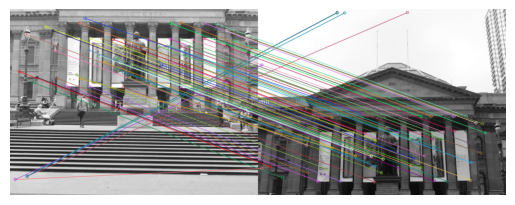

In [636]:
set1_feature_matches = []
for src_idx in range(len(set1_images)):
    src_matches = []
    for dst_idx in range(len(set1_images)):
        if src_idx != dst_idx:
            src_matches.append(get_feature_matches(set1_feature_descriptors[src_idx], set1_feature_descriptors[dst_idx]))
    set1_feature_matches.append(src_matches)
pairs_idx = np.array([(i,i) for i in range(len(set1_feature_matches[0][0]))])
plt.imshow(drawMatches(set1_images[1], set1_feature_matches[0][0][:,1], set1_images[0], set1_feature_matches[0][0][:,0], pairs_idx))
plt.axis('off')

In [637]:
def ransac(matches, threshold, n_max):
    '''
    Random Sampling Concensus
    '''
    # Convert from matrix indicies to image coordinates
    matches = np.array([((src[1], src[0]),(dst[1], dst[0])) for src, dst in matches])
    inliers = {}
    # Compute the homography for all the points
    H = est_homography(matches[:,0], matches[:,1])
    num_matches = len(matches)
    for _ in range(n_max):
        # Randomly pick 4 feature matches (distinct)
        feature_sample = []
        rand_idxs = []
        for _ in range(4):
            rand_idx = np.random.choice(num_matches)
            while rand_idx in rand_idxs:
                rand_idx = np.random.choice(num_matches)
            rand_idxs.append(rand_idx)
            feature_sample.append(matches[rand_idx])
        feature_sample = np.array(feature_sample)
        # Apply the homography to points image 1
        Hp_src = apply_homography(H, feature_sample[:,0])
        # Get the distances from points in image 2 to the estimated points in Hp_src
        distances = np.sqrt(np.sum(np.abs(Hp_src - feature_sample[:,1]) ** 2, axis=1))
        # Keep only the points whose distances are below the threshold
        inliers.update(([(tuple(match[0]), tuple(match[1])) for match, distance in zip(feature_sample, distances) if distance < threshold]))
    # Obtain the largest set of inliers
    best_inliers = np.array([[match[0], match[1]] for match in inliers.items()])
    # Recompute linear least squares using the largest set
    # of inliers to obtain the estimated homography
    H_est = est_homography(best_inliers[:,0], best_inliers[:,1])
    return H_est, best_inliers

(-0.5, 1199.5, 449.5, -0.5)

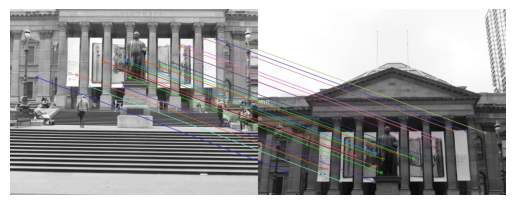

In [638]:
H_est, inliers = ransac(set1_feature_matches[0][0], 85, 1000)

set1_homographies = []
set1_inliers = []

for src_idx in range(len(set1_feature_matches)):
    src_homographies = []
    src_inliers = []
    for dst_idx in range(len(set1_feature_matches[src_idx])):
        H_est, inliers = ransac(set1_feature_matches[src_idx][dst_idx], 45, 1000)
        sinliers = np.array([((src[1], src[0]),(dst[1], dst[0])) for [src, dst] in inliers])
        src_homographies.append(H_est)
        src_inliers.append(sinliers)
    set1_homographies.append(src_homographies)
    set1_inliers.append(src_inliers)
    
im1 = set1_images[0]
im2 = set1_images[1]
kp1 = np.array(set1_inliers[0][0][:,0], dtype=object)
kp2 = np.array(set1_inliers[0][0][:,1], dtype=object)
idx_pairs = np.array([(i,idx) for i, (idx, val) in zip(range(len(kp1)), enumerate(kp2)) if type(val) == type(kp1[i:0])])

image = drawMatches(im2, kp2, im1, kp1, idx_pairs)
plt.imshow(image)
plt.axis('off')

(-0.5, 1199.5, 449.5, -0.5)

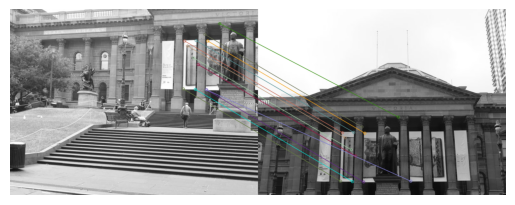

In [639]:
im1 = set1_images[0]
im3 = set1_images[2]
kp1 = np.array(set1_inliers[0][1][:,0], dtype=object)
kp3 = np.array(set1_inliers[0][1][:,1], dtype=object)
idx_pairs = np.array([(i,idx) for i, (idx, val) in zip(range(len(kp1)), enumerate(kp2)) if type(val) == type(kp1[i:0])])

image = drawMatches(im3, kp3, im1, kp1, idx_pairs)
plt.imshow(image)
plt.axis('off')

In [640]:
def blend_images(images, homographies):
    '''
    Blends images
    '''
    # Apply homography to each image

    # Calculate bounding boxes for each image

    # Take the largest bounding box as the canvas size
    
    # H_inverse = np.linalg.inv(H)
    canvas_size = (images[0].shape[1], images[0].shape[0])
    canvas_size = (900,900)
    # print(images[1].shape)
    # corners = np.array([[0,0],[images[1].shape[1], 0], [0, images[1].shape[0]], [images[1].shape[1], images[1].shape[0]]])
    # plt.scatter(corners[:,0], corners[:,1], c='r', s=10)
    # corners_tr = apply_homography(H, corners)
    # print(corners_tr)
    # plt.scatter(corners_tr[:,0], corners_tr[:,1], c='b', s=10)
    # w1_image = cv2.warpPerspective(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB), H, (images[0].shape[1] , images[0].shape[0]))
    # w1_image = cv2.warpPerspective(cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB), H, (images[0].shape[1], images[0].shape[0]))
    # warped_image = cv2.warpPerspective(images[1], H, canvas_size)
    # plt.imshow(w1_image)
    # plt.imshow(w2_image)
    bounding_boxes = []
    # im1_transformed = apply_homography(H, inliers[0][:,0])
    # im2_transformed = apply_homography(H, inliers[0][:,1])
    # im1_bounding_box = []
    # im2_bounding_box = []
    # tbb = []
    # for coord in range(2):
    #     im1_bounding_box.append((np.min(im1_transformed[:,coord]), np.max(im1_transformed[:,coord])))
    #     im2_bounding_box.append((np.min(im2_transformed[:,coord]), np.max(im2_transformed[:,coord])))
    #     tbb.append((np.min(inliers[0][:,coord]), np.max(inliers[0][:,coord])))

    img = np.zeros(canvas_size, dtype=np.uint8)
    img = cv2.warpPerspective(images[0], np.identity(3), canvas_size, img, borderMode=cv2.BORDER_TRANSPARENT)
    img = cv2.warpPerspective(images[1], homographies[0], canvas_size, img, flags=cv2.WARP_INVERSE_MAP+cv2.INTER_LINEAR, borderMode=cv2.BORDER_TRANSPARENT)
    # img = cv2.warpPerspective(images[2], homographies[1], canvas_size, img, flags=cv2.WARP_INVERSE_MAP+cv2.INTER_LINEAR, borderMode=cv2.BORDER_TRANSPARENT)
    # Warp images on top of eachother
    # plt.imshow(f)
    # print(tbb)
    # print(im1_bounding_box)
    # print(im2_bounding_box)
    # warped_image = cv2.warpPerspective(images[0], H, (600,450))#images[0].shape)
    # warped_image = cv2.warpPerspective(images[1], H, images[1].shape)
    return img
    # return cv2.warpPerspective(images[0], H, images[0].shape)

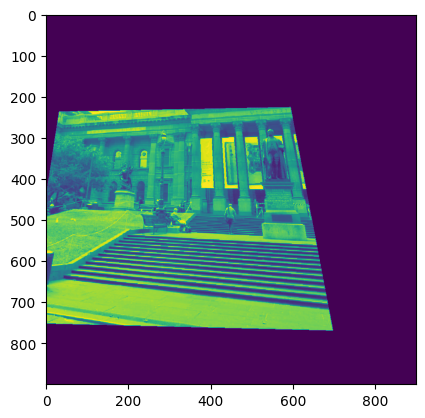

In [641]:
# TODO Add code to perform image blending
images = set1_images # np.array(set1_images)
H = set1_homographies[0]
inliers = np.array(set1_inliers[0], dtype=object)
f = np.zeros((900,900), dtype=np.uint8)

# f = cv2.warpPerspective(images[0], np.identity(3), (900,900), f, borderMode=cv2.BORDER_TRANSPARENT)
f = cv2.warpPerspective(images[2], set1_homographies[0][0], (900,900), f, flags=cv2.WARP_INVERSE_MAP)
plt.imshow(f)
b = blend_images(images, H)

(-0.5, 899.5, 899.5, -0.5)

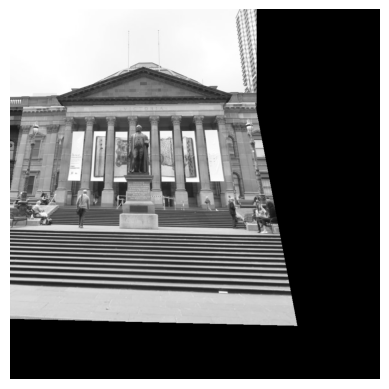

In [642]:
plt.imshow(cv2.cvtColor(b, cv2.COLOR_BGR2RGB))
plt.axis('off')